In [3]:
import numpy as np

# Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline


# Numerical integration with variable-step methods

Previously, we encountered fixed-step integrators, which take steps towards the solution of an initial value problem using a fixed time step $\Delta t$. In this notebook, we will explore variable-step integrators, which take steps of varying size to achieve a desired accuracy.


### Relationship to optimization

In optimization, we saw second-order methods like Newton's method, in which the gradient descent step scales inversely with the local concavity. In numerical integration, we will see methods that scale inversely with the local smoothness. This is a common theme in numerical methods: we want to take steps that are inversely proportional to the local smoothness of the problem.

### The Hadley Cell model

+ As our toy system for today's notebook, we will use the low-order Hadley cell model, which is derived from the coupled dynamics of atomospheric temperature and water vapor

+ We'll start by generating a reference trajectory using an existing integrator `scipy.solve_ivp`

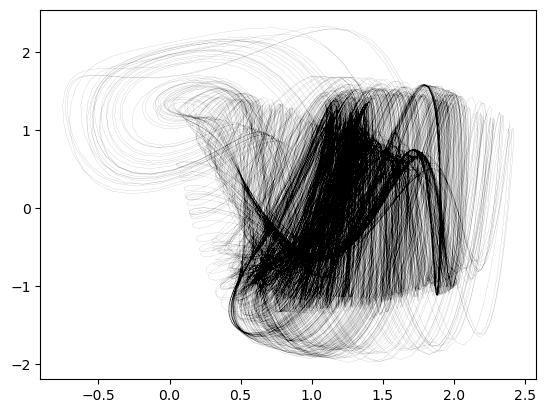

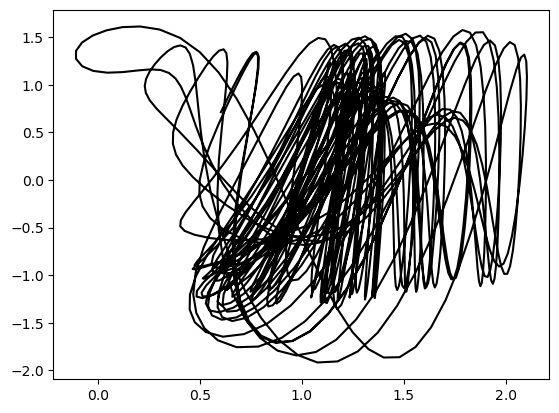

In [6]:
class Hadley:

    def __init__(self, a=0.2, b=4, f=9, g=1):
        self.a = a
        self.b = b
        self.f = f
        self.g = g
        self.name = self.__class__.__name__

    def rhs(self, t, X):
        x, y, z = X
        xdot = -(y ** 2) - z ** 2 - self.a * x + self.a * self.f
        ydot = x * y - self.b * x * z - y + self.g
        zdot = self.b * x * y + x * z - z
        return np.array([xdot, ydot, zdot])
    
    def __call__(self, t, X):
        return self.rhs(t, X)


from scipy.integrate import solve_ivp
ic = np.array([1.37, 0.93, 0.64])

hadley = Hadley()
sol = solve_ivp(hadley, [0, 2000], ic, method='RK45', rtol=1e-6, atol=1e-6)

plt.figure()
plt.plot(sol.y[0], sol.y[1], color='k', linewidth=0.05)


plt.figure()
sol = solve_ivp(hadley, [0, 100], ic, method='RK45', rtol=1e-6, atol=1e-6)
plt.plot(sol.y[0], sol.y[1],  color='k')


## Variable-step methods

Previously, we solved the initial value problem

$$
\begin{align}
\dot{\mathbf{x}}(t) &= \mathbf{f}(t, \mathbf{x}(t)) \\
\mathbf{x}(t_0) &= \mathbf{x}_0
\end{align}
$$

by taking steps of size $\Delta t$ in time, for example by using the Euler method,

$$
\mathbf{x}_{n+1} = \mathbf{x}_n + \Delta t \, \mathbf{f}(t_n, \mathbf{x}_n)
$$

We will instead add an additional update step to the Euler method, which will allow us to take steps of varying size. This is reminiscent of our optimization module, where for certain methods we changed the learning rate adaptively in each step.

### Euler's method with a variable step size

Recall that we defined the local error in terms of the error introduced into our integration solution by taking a single step of size $\Delta t$,

$$
\begin{align}
\mathbf{e}_n &= \mathbf{x}(t_n) - \mathbf{x}_n \\
&= \mathbf{x}(t_n) - \mathbf{x}_{n -1} - \Delta t \, \mathbf{f}(t_{n -1}, \mathbf{x}_{n-1})
\end{align}
$$

where $\mathbf{x}(t_n)$ is the exact solution at time $t_n

### How do we reduce the error?

In principle, we can always reduce the error of our integration by taking a smaller step size $\Delta t$. But how much should we decrease $\Delta t$? We can use the local error to determine this. At each step, we compute an estimate of the local error $\mathbf{e}_n$ by comparing our current solution $\mathbf{x}_n$ to solution we would have arrived at if we had instead taken two half steps of size $\Delta t/2$.

We call this approximate local error estimate $\tilde{\mathbf{e}}_n$,

$$
\mathbf{x}_{n - 1/2} \equiv \mathbf{x}_{n -1} + \frac{\Delta t}{2} \, \mathbf{f}(t_{n -1}, \mathbf{x}_{n-1})
$$
$$
\tilde{\mathbf{e}}_n = \bigg(\mathbf{x}_{n - 1/2}+ \frac{\Delta t}{2} \, \mathbf{f}(t_{n -1/2}, \mathbf{x}_{n-1/2}) \bigg) - \bigg(\mathbf{x}_{n -1} + \Delta t \, \mathbf{f}(t_{n -1}, \mathbf{x}_{n-1})\bigg)
$$

We define a cutoff $||\tilde{\mathbf{e}}_n ||$ known as the relative tolerance, $r$. If our error is below this threshold, then we accept the step at the current value of $\Delta t$. If the error exceeds this number, then instead we update our step size $\Delta t$ at a rate proportional to the error $||\tilde{\mathbf{e}}_n ||$

$$
\Delta t_{n+1} = \Delta t_n \, 0.9 \,\bigg(\frac{r}{\|\tilde{\mathbf{e}}_n\|}\bigg)^{1/2}
$$

The factor of $r$ ensures that we do not take steps that are too small, and the factor of $\|\tilde{\mathbf{e}}_n\|$ ensures that we do not take steps that are too large. The $0.9$ factor is a safety factor to ensure that we do not take steps that are too large.





In [12]:
class EulerTwoStep:
    """
    An adaptive Euler integration scheme that estimates local error based on partial
    steps 
    """

    def __init__(self, dt=1e-3, rtol=1e-2, max_iter=1e8):
        self.dt = dt
        self.name = self.__class__.__name__
        self.rtol = rtol
        self.max_iter = max_iter

    def integrate(self, f, tspan, y):
        """Integrate the system using the Euler method"""
        
        dt_init = self.dt
        y_vals = [y.copy()]
        t = tspan[0]
        t_vals = [t]
        num_iter = 0
        while t < tspan[-1]:

            ## Euler step
            y_next = y_vals[-1] + self.dt * f(t, y_vals[-1])

            ## Euler step with half step
            y_half = y_vals[-1] + 0.5 * self.dt * f(t, y_vals[-1])
            y_next_half = y_half + 0.5 * self.dt * f(t + 0.5 * self.dt, y_half)

            ## Error estimate
            err = np.linalg.norm(y_next - y_next_half)

            ## Accept step if error is small enough
            if err < self.rtol:
                t += self.dt
                y_vals.append(y_next)
                t_vals.append(t)
                self.dt = dt_init

            ## Otherwise, reduce step size
            else:
                self.dt *= 0.9 * np.sqrt(self.rtol / err)

            if num_iter > self.max_iter:
                print("Max iterations reached")
                break


        self.t, self.y = np.array(t_vals), np.array(y_vals)
        return self
        



## Compare two-step adaptive Euler to a built-in adaptive integrator

Text(0.5, 1.0, 'Scipy')

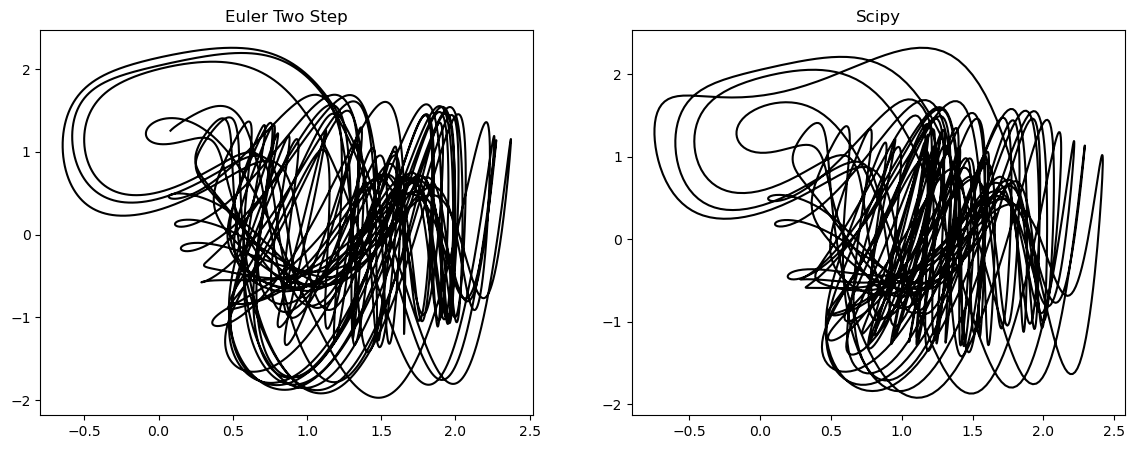

In [13]:
plt.figure(figsize=(14, 5))
integrator = EulerTwoStep(dt=1e-2, rtol=1e-7)
integrator.integrate(hadley, [0, 100], ic)
plt.subplot(1, 2, 1)
plt.plot(integrator.y[:, 0], integrator.y[:, 1], color='k')
plt.title("Euler Two Step")

plt.subplot(1, 2, 2)
sol = solve_ivp(hadley, [0, 100], ic, method='Radau', rtol=1e-6, atol=1e-6)
plt.plot(sol.y[0], sol.y[1],  color='k')
plt.title("Scipy")

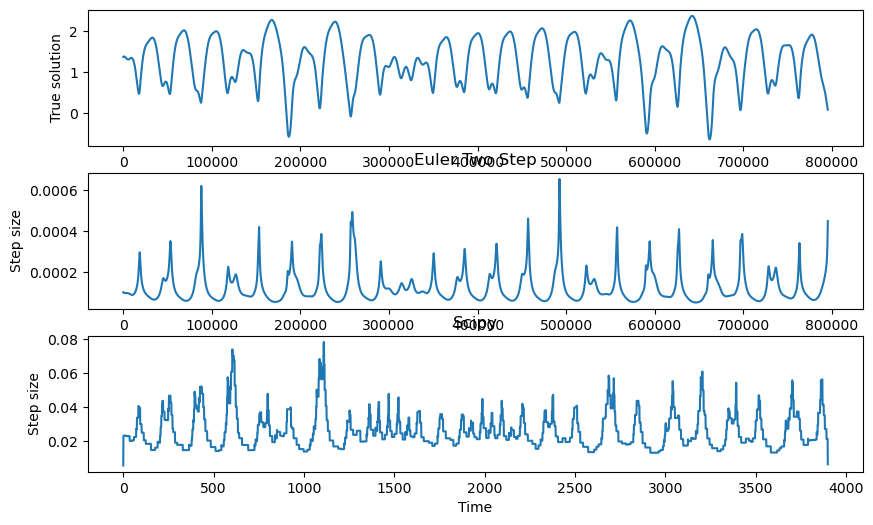

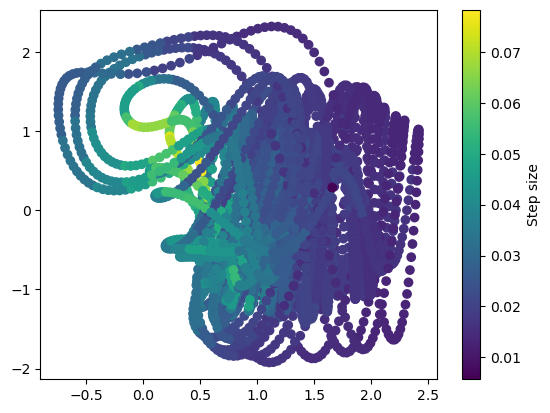

In [21]:
plt.figure(figsize=(10, 6))


plt.subplot(3, 1, 1)
plt.plot(integrator.y[:, 0])
plt.xlabel("Time")
plt.ylabel("True solution")
# plt.title("Euler Two Step")

plt.subplot(3, 1, 2)
plt.plot(np.diff(integrator.t))
plt.xlabel("Time")
plt.ylabel("Step size")
plt.title("Euler Two Step")

plt.subplot(3, 1, 3)
plt.plot(np.diff(sol.t))
plt.xlabel("Time")
plt.ylabel("Step size")
plt.title("Scipy")


plt.figure()
plt.scatter(sol.y[0][:-1], sol.y[1][:-1],  c=np.diff(sol.t))
plt.colorbar(label="Step size")

## Some things to try

+ Try varying the relative tolerance $\epsilon$ and see how the solution changes.
+ Try varying the initial step size $\Delta t_0$ and see how the solution changes.
+ What are some drawbacks of this method? How might we improve it?

## Embedded methods

The Runge-Kutta-Fehlberg method is a variable-step method that is *embedded*, meaning that it is a pair of methods where one is more accurate than the other. We can think of embedded methods as generalizing the idea of computing a regular step and a half step to estimate local error in Euler's method. 

The embedded version of Runge-Kutta 4(5) is given by

<!-- $$
\begin{align}
\mathbf{k}_1 &= \Delta t \, \mathbf{f}(t_n, \mathbf{x}_n) \\
\mathbf{k}_2 &= \Delta t \, \mathbf{f}(t_n + \frac{\Delta t}{4}, \mathbf{x}_n + \frac{\mathbf{k}_1}{4}) \\
\mathbf{k}_3 &= \Delta t \, \mathbf{f}(t_n + \frac{\Delta t}{4}, \mathbf{x}_n + \frac{\mathbf{k}_1}{8} + \frac{\mathbf{k}_2}{8}) \\
\mathbf{k}_4 &= \Delta t \, \mathbf{f}(t_n + \frac{\Delta t}{2}, \mathbf{x}_n - \frac{\mathbf{k}_2}{2} + \mathbf{k}_3) \\
\mathbf{k}_5 &= \Delta t \, \mathbf{f}(t_n + \frac{3 \Delta t}{4}, \mathbf{x}_n + \frac{3 \mathbf{k}_1}{16} + \frac{9 \mathbf{k}_4}{16}) \\
\mathbf{k}_6 &= \Delta t \, \mathbf{f}(t_n + \Delta t, \mathbf{x}_n - \frac{3 \mathbf{k}_1}{7} + \frac{2 \mathbf{k}_2}{7} + \frac{12 \mathbf{k}_3}{7} - \frac{12 \mathbf{k}_4}{7} + \frac{8 \mathbf{k}_5}{7}) \\
\mathbf{x}_{n+1} &= \mathbf{x}_n + \frac{7 \mathbf{k}_1}{90} + \frac{32 \mathbf{k}_3}{90} + \frac{12 \mathbf{k}_4}{90} + \frac{32 \mathbf{k}_5}{90} + \frac{7 \mathbf{k}_6}{90} \\
\mathbf{y}_{n+1} &= \mathbf{x}_n + \frac{7 \mathbf{k}_1}{360} + \frac{32 \mathbf{k}_3}{360} + \frac{12 \mathbf{k}_4}{360} + \frac{32 \mathbf{k}_5}{360} + \frac{7 \mathbf{k}_6}{360}
\end{align}
$$

where $\mathbf{y}_{n+1}$ is the higher-order method, and $\mathbf{x}_{n+1}$ is the lower-order method. The error is given by -->


$$
\begin{align}
\mathbf{k}_1 &= \Delta t \, \mathbf{f}(t_n, \mathbf{x}_n) \\
\mathbf{k}_2 &= \Delta t \, \mathbf{f}(t_n + \frac{\Delta t}{4}, \mathbf{x}_n + \frac{\mathbf{k}_1}{4}) \\
\mathbf{k}_3 &= \Delta t \, \mathbf{f}(t_n + \frac{3\Delta t}{8}, \mathbf{x}_n + \frac{3\mathbf{k}_1}{32} + \frac{\mathbf{k}_2}{32}) \\
\mathbf{k}_4 &= \Delta t \, \mathbf{f}(t_n + \frac{12\Delta t}{13}, \mathbf{x}_n + \frac{1932\mathbf{k}_1}{2197} - \frac{7200\mathbf{k}_2}{2197} + \frac{7296\mathbf{k}_3}{2197}) \\
\mathbf{k}_5 &= \Delta t \, \mathbf{f}(t_n + \Delta t, \mathbf{x}_n + \frac{439\mathbf{k}_1}{216} - 8\mathbf{k}_2 + \frac{3680\mathbf{k}_3}{513} - \frac{845\mathbf{k}_4}{4104}) \\
\mathbf{k}_6 &= \Delta t \, \mathbf{f}(t_n + \frac{\Delta t}{2}, \mathbf{x}_n - \frac{8\mathbf{k}_1}{27} + 2\mathbf{k}_2 - \frac{3544\mathbf{k}_3}{2565} + \frac{1859\mathbf{k}_4}{4104} - \frac{11\mathbf{k}_5}{40}) \\
\mathbf{x}_{n+1} &= \mathbf{x}_n + \frac{25\mathbf{k}_1}{216} + \frac{1408\mathbf{k}_3}{2565} + \frac{2197\mathbf{k}_4}{4104} - \frac{\mathbf{k}_5}{5} \\
\mathbf{y}_{n+1} &= \mathbf{x}_n + \frac{16\mathbf{k}_1}{135} + \frac{6656\mathbf{k}_3}{12825} + \frac{28561\mathbf{k}_4}{56430} - \frac{9\mathbf{k}_5}{50} + \frac{2\mathbf{k}_6}{55}
\end{align}
$$

where $\mathbf{y}_{n+1}$ is the 5th order solution, and $\mathbf{x}_{n+1}$ is the 4th order solution. The error estimate is given by


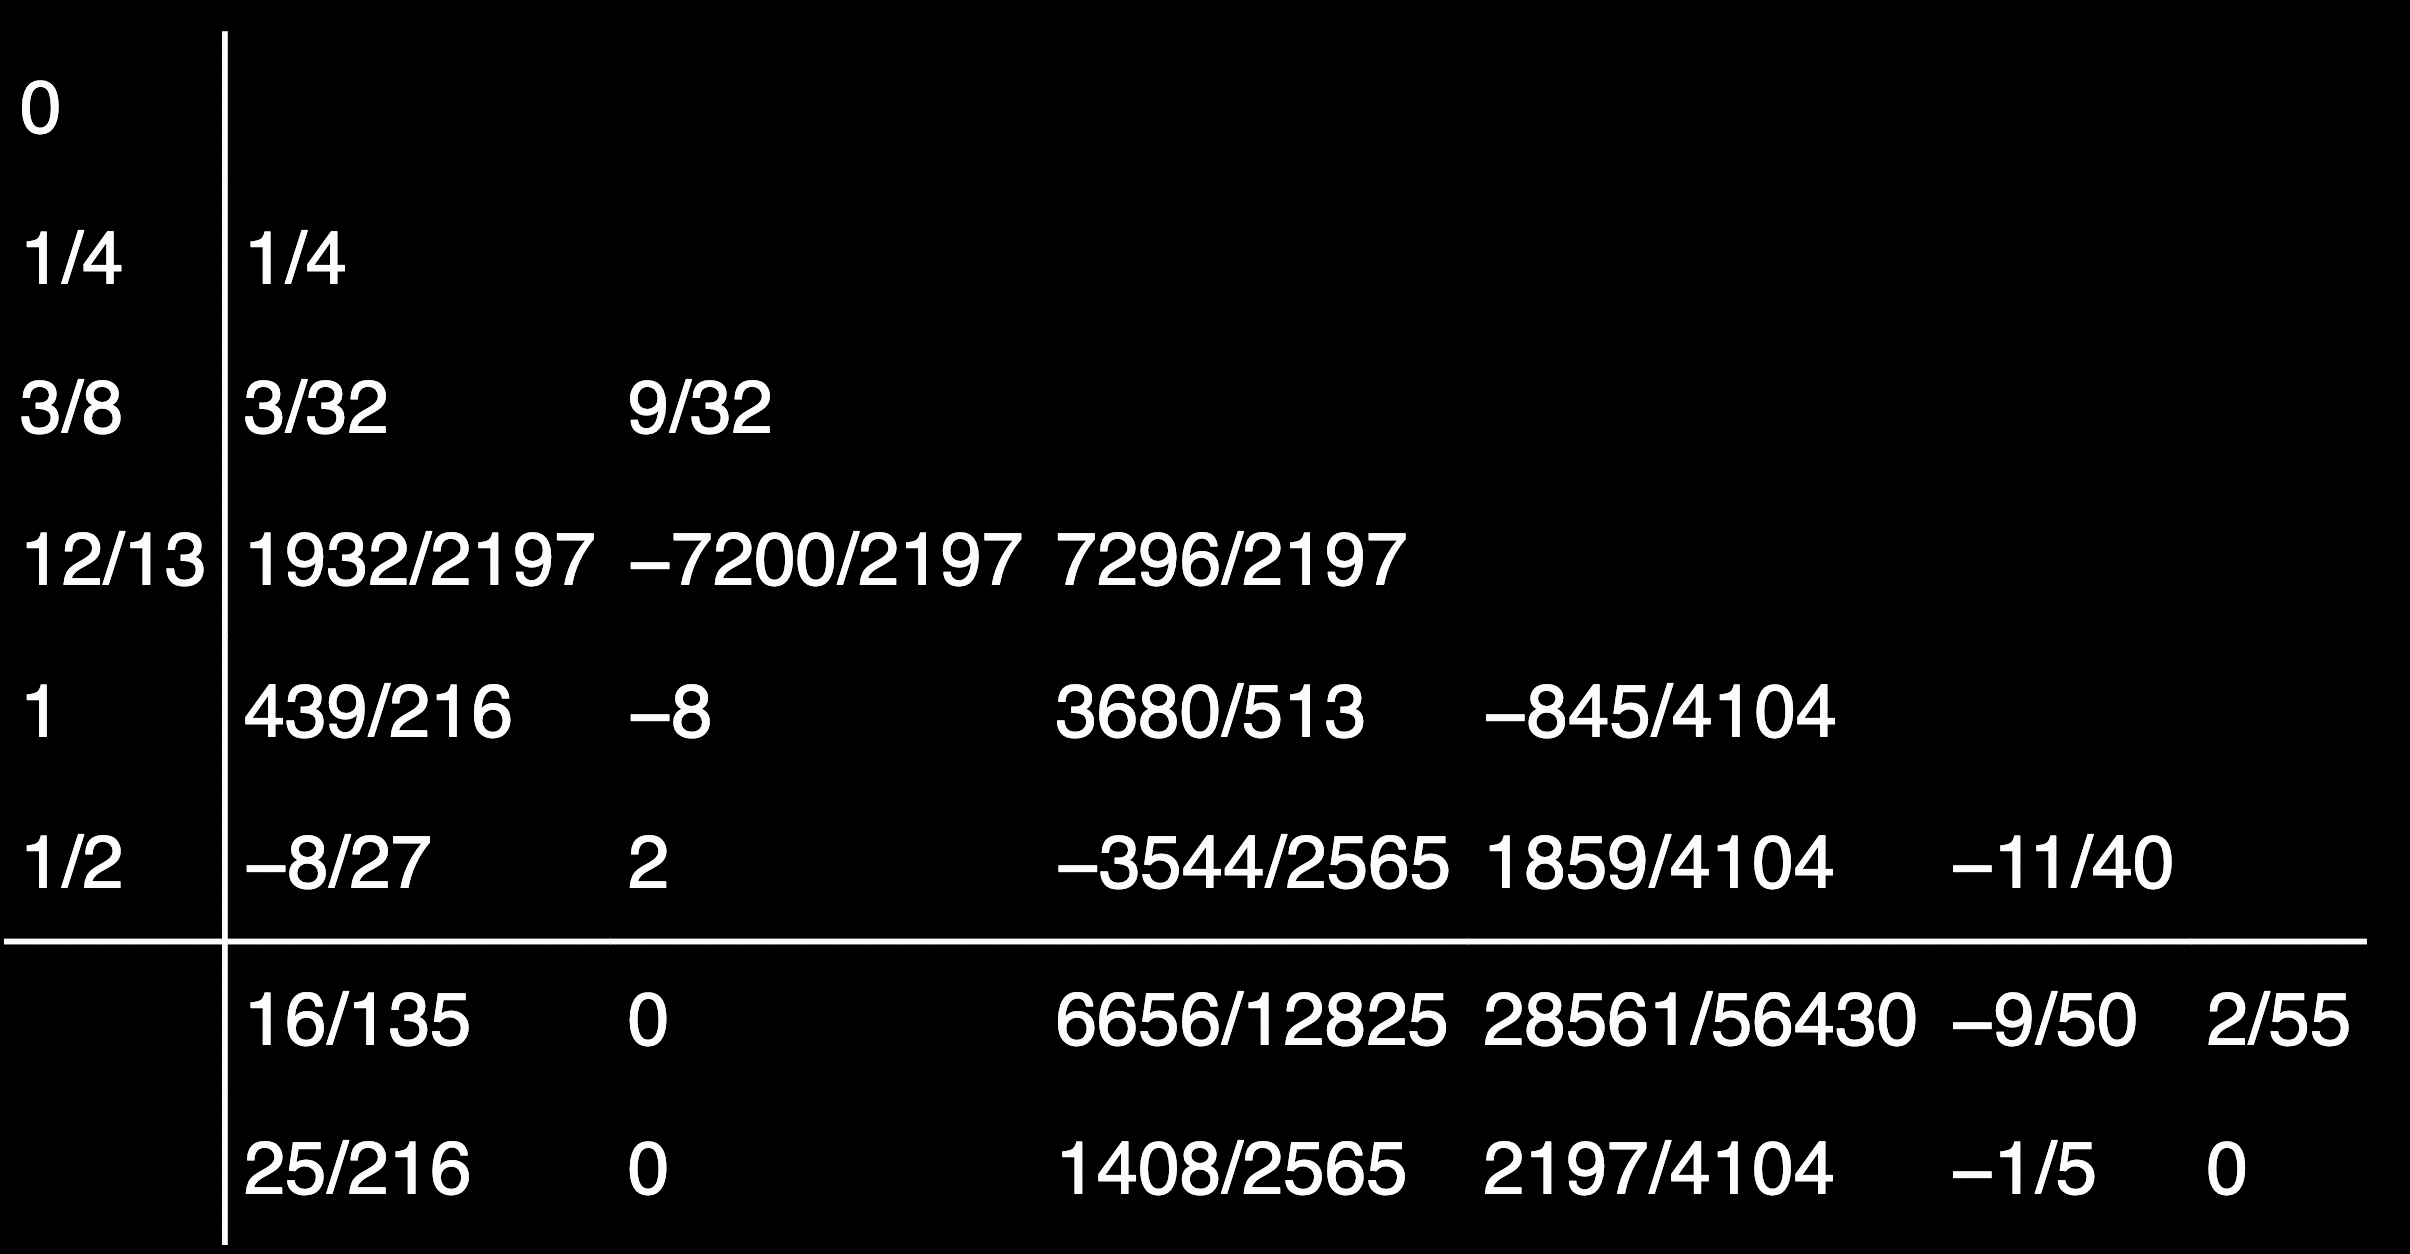

In [167]:
Image(filename='../resources/rkf_butcher.png', width=750)
# The Butcher tableau for the RKF45 method has an extra line

Just like the two-step Euler method, we estimate the local (step-wise) truncation error by comparing the two solutions. The error estimate is given by

$$
\mathbf{e}_{n+1} = \mathbf{y}_{n+1} - \mathbf{x}_{n+1}
$$

The error is estimated by

$$
\mathcal{E} = \frac{1}{\Delta t} \left\| \mathbf{e}_{n+1} \right\|_2
$$

The error is then used to determine the next step size, $\Delta t_{n+1}$, by

$$
\Delta t_{n+1} = \Delta t \, (0.9)\left( \frac{\epsilon}{\mathcal{E}} \right)^{1/4}
$$

where $\epsilon$ is a desired accuracy. The step size is bounded by $\Delta t_{\text{min}}$ and $\Delta t_{\text{max}}$.

In [22]:
class RungeKuttaFehlberg:

    def __init__(self, dt=1e-3, rtol=1e-2, max_iter=1e8):
        self.dt = dt
        self.name = self.__class__.__name__
        self.rtol = rtol
        self.max_iter = max_iter

    def integrate(self, f, tspan, y):
        """Integrate the system using the Euler method"""
        
        dt_init = self.dt
        y_vals = [y.copy()]
        t = tspan[0]
        t_vals = [t]
        num_iter = 0
        while t < tspan[-1]:

            k1 = f(t, y_vals[-1])
            k2 = f(t + 0.25 * self.dt, y_vals[-1] + 0.25 * self.dt * k1)
            k3 = f(t + 0.375 * self.dt, y_vals[-1] + 0.09375 * self.dt * k1 + 0.28125 * self.dt * k2)
            k4 = f(t + 12/13 * self.dt, y_vals[-1] + 1932/2197 * self.dt * k1 - 7200/2197 * self.dt * k2 + 7296/2197 * self.dt * k3)
            k5 = f(t + self.dt, y_vals[-1] + 439/216 * self.dt * k1 - 8 * self.dt * k2 + 3680/513 * self.dt * k3 - 845/4104 * self.dt * k4)
            k6 = f(t + 0.5 * self.dt, y_vals[-1] - 8/27 * self.dt * k1 + 2 * self.dt * k2 - 3544/2565 * self.dt * k3 + 1859/4104 * self.dt * k4 - 11/40 * self.dt * k5)

            y_next = y_vals[-1] + self.dt * (25/216 * k1 + 1408/2565 * k3 + 2197/4104 * k4 - 1/5 * k5)
            y_next_half = y_vals[-1] + self.dt * (16/135 * k1 + 6656/12825 * k3 + 28561/56430 * k4 - 9/50 * k5 + 2/55 * k6)

            err = np.linalg.norm(y_next - y_next_half) / self.dt

            ## Accept step if error is small enough
            if err < self.rtol:
                t += self.dt
                y_vals.append(y_next)
                t_vals.append(t)
                self.dt = dt_init

            ## Otherwise, reduce step size
            else:
                self.dt *= 0.9 * np.sqrt(self.rtol / err)**(1/5)

            if num_iter > self.max_iter:
                print("Max iterations reached")
                break

        self.t, self.y = np.array(t_vals), np.array(y_vals)
        return self

Text(0.5, 1.0, 'Scipy')

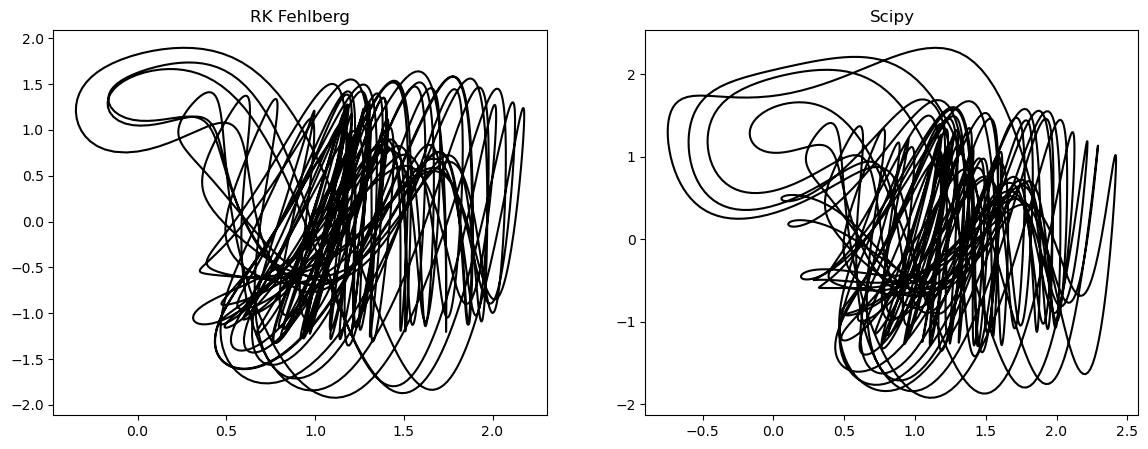

In [30]:
plt.figure(figsize=(14, 5))
integrator = RungeKuttaFehlberg(dt=1e-1, rtol=1e-6)
integrator.integrate(hadley, [0, 100], ic)
plt.subplot(1, 2, 1)
plt.plot(integrator.y[:, 0], integrator.y[:, 1], color='k')
plt.title("RK Fehlberg")


plt.subplot(1, 2, 2)
sol0 = solve_ivp(hadley, [0, 100], ic, method='Radau', rtol=1e-6, atol=1e-6, max_step=1e-1)
plt.plot(sol0.y[0], sol0.y[1],  color='k')
plt.title("Scipy")

Text(0.5, 1.0, 'Scipy')

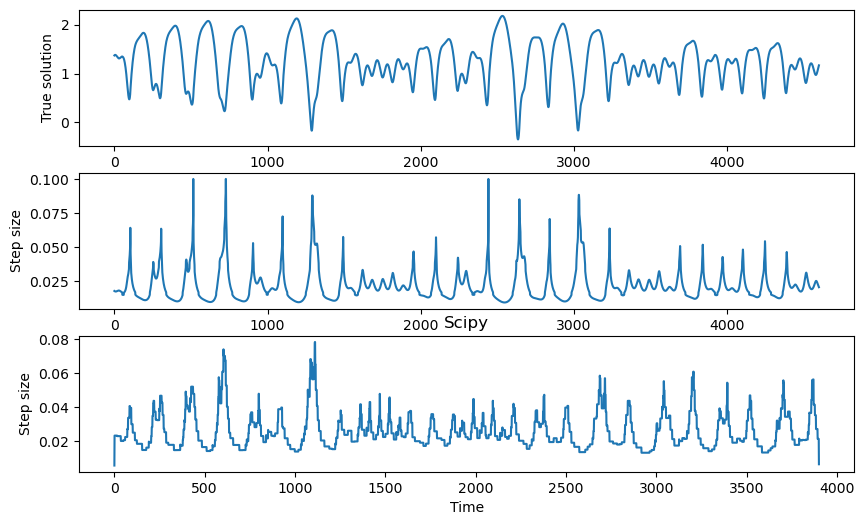

In [33]:
plt.figure(figsize=(10, 6))


plt.subplot(3, 1, 1)
plt.plot(integrator.y[:, 0])
plt.xlabel("Time")
plt.ylabel("True solution")

plt.subplot(3, 1, 2)
plt.plot(np.diff(integrator.t))
plt.xlabel("Time")
plt.ylabel("Step size")

plt.subplot(3, 1, 3)
plt.plot(np.diff(sol.t))
plt.xlabel("Time")
plt.ylabel("Step size")
plt.title("Scipy")


# Stochastic differential equations

What if our differential equation has a stochastic component? We can use the same methods as before, but we need to take into account the stochastic component. We will use the Euler-Maruyama method, which is a first-order method for stochastic differential equations. The method is given by

$$
\begin{align}
\mathbf{x}_{n+1} &= \mathbf{x}_n + \Delta t\; \mathbf{f}(\mathbf{x}_n) + \sqrt{\Delta t}\; g(\mathbf{x}_n) \xi_n \\
\xi_n &\sim \mathcal{N}(0, 1)
\end{align}
$$

+ Notice that this is similar to how we implemented Ornstein-Uhlenbeck dynamics earlier in the course. We are just replacing the harmonic oscillator forcing with our general right hand side. 
+ We scale our noise term by $\sqrt{\Delta t}$. Recall that Brownian motion has a mean *square* displacement that scales as $\Delta t$, which corresponds to the average distance from origin scaling as $\sqrt{t}$.

+ Nice discussion of more sophisticated methods, as well as Ito and Stratonovich calculus, by [Tim Sauer here](https://math.gmu.edu/~tsauer/pre/sde.pdf)


Text(0.5, 1.0, 'Euler-Maruyama')

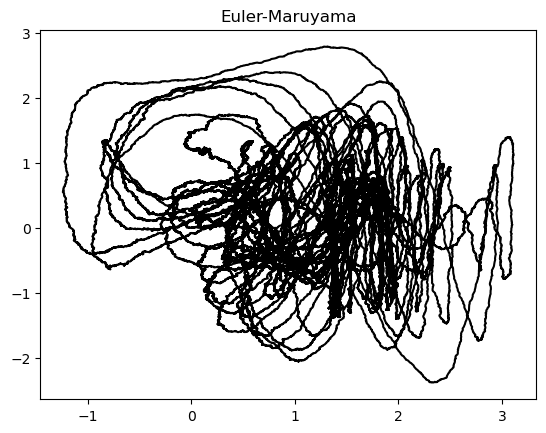

In [135]:
class EulerMaruyama:
    
    def __init__(self, dt=1e-3, noise=1e-2):
        self.dt = dt
        self.name = self.__class__.__name__
        self.noise = noise


    def integrate(self, f, tspan, y):
        t_eval = np.arange(tspan[0], tspan[-1], self.dt)
        t_list = [tspan[0]]
        y_list = [y.copy()]
        for t in t_eval:
            y = y + self.dt * f(t, y) + self.noise * np.sqrt(self.dt) * np.random.randn(*y.shape)
            t_list.append(t)
            y_list.append(y.copy())
        self.t, self.y = np.array(t_list), np.array(y_list)
        return self

integrator = EulerMaruyama(dt=1e-3, noise=1e-1)
integrator.integrate(hadley, [0, 100], ic)
plt.plot(integrator.y[:, 0], integrator.y[:, 1], color='k')
plt.title("Euler-Maruyama")

# Symplectic integration

+ Suppose that we want to integrate a system with an explicit conserved quantity, like a Hamiltonian or a stream function.

+ We will pick a dynamical system with a conserved invariant: the total mechanical energy

Text(0, 0.5, 'Total Mechanical Energy')

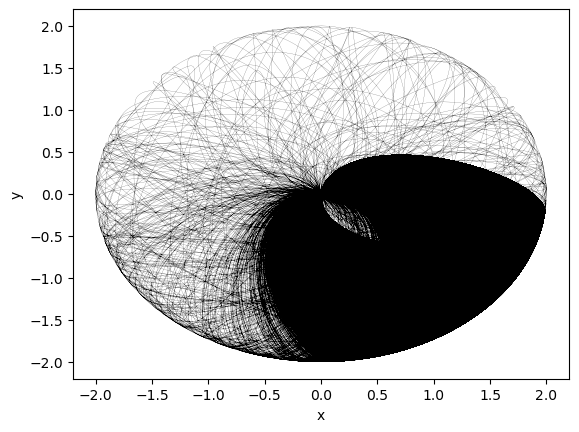

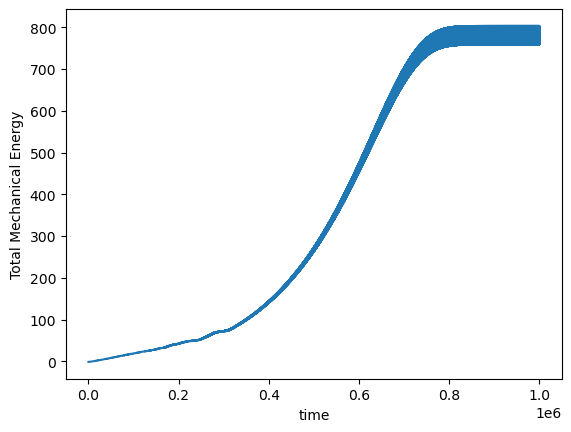

In [127]:


class DoublePendulum:

    def __init__(self, g=9.82, l1=1.0, l2=1.0, m1=1.0, m2=1.0):
        self.g = g
        self.l1 = l1
        self.l2 = l2
        self.m1 = m1
        self.m2 = m2

    def __call__(self, t, x):
        g = self.g
        l1 = self.l1
        l2 = self.l2
        m1 = self.m1
        m2 = self.m2

        theta1, theta2, omega1, omega2 = x

        delta_theta = theta1 - theta2

        denom = (2 * m1 + m2 - m2 * np.cos(2 * delta_theta))

        dtheta1 = omega1
        domega1 = ((-g * (2 * m1 + m2) * np.sin(theta1) - m2 * g * np.sin(theta1 - 2 * theta2) - 2 * np.sin(delta_theta) * m2 * (omega2**2 * l2 + omega1**2 * l1 * np.cos(delta_theta))) / (l1 * denom))

        dtheta2 = omega2
        domega2 = ((2 * np.sin(delta_theta) * (omega1**2 * l1 * (m1 + m2) + g * (m1 + m2) * np.cos(theta1) + omega2**2 * l2 * m2 * np.cos(delta_theta))) / (l2 * denom))

        return np.array([dtheta1, dtheta2, domega1, domega2])
    
    def convert_to_physical(self, y):
        """
        Given a vector of coordinates in the form angle1, angle2, omega1, omega2, 
        convert to physical coordinates of the tips of the pendulums
        """
        l1 = self.l1
        l2 = self.l2
        theta1, theta2 = y[:, 0], y[:, 1]
        x1 = l1 * np.sin(theta1)
        y1 = -l1 * np.cos(theta1)
        x2 = x1 + l2 * np.sin(theta2)
        y2 = y1 - l2 * np.cos(theta2)
        return np.array([x1, y1, x2, y2]).T
    
    def compute_energy(self, y):
        g = self.g
        l1 = self.l1
        l2 = self.l2
        m1 = self.m1
        m2 = self.m2
        theta1, theta2 = y[:, 0], y[:, 1]
        omega1, omega2 = y[:, 2], y[:, 3]
        
        delta_theta = theta1 - theta2

        T = 0.5 * m1 * l1**2 * omega1**2 + 0.5 * m2 * (l1**2 * omega1**2 + l2**2 * omega2**2 + 2 * l1 * l2 * omega1 * omega2 * np.cos(delta_theta))
        U = - m1 * g * l1 * np.cos(theta1) - m2 * g * (l1 * np.cos(theta1) + l2 * np.cos(theta2))
        
        E = T + U
        return E
    
class Euler:
    """The Euler integration scheme"""

    def __init__(self, dt=1e-3):
        self.dt = dt
        self.name = self.__class__.__name__

    def integrate(self, f, tspan, y):
        """Integrate the system using the symplectic Euler method"""
        
        m = len(y) // 2
        y_vals = [y.copy()]
        t = tspan[0]
        t_vals = [t]
        while t < tspan[-1]:
            
            yprev = y_vals[-1].copy()
            y_vals.append(yprev + self.dt * f(t, yprev))

            t += self.dt
            t_vals.append(t)

        self.t, self.y = np.array(t_vals), np.array(y_vals)
        return self

pendulum = DoublePendulum()

from scipy.integrate import solve_ivp

# Initial conditions
x0 = np.array([np.pi / 2.1, np.pi / 2, 0.1, 0.2])
t0 = 0.0

# # Set up integrator
# integrator = solve_ivp(pendulum, [t0, 1000], x0, method='RK45', max_step=1e-3)
# # Convert to physical coordinates
# y = pendulum.convert_to_physical(integrator.y.T)
# Set up integrator
integrator = Euler(dt=1e-3)
integrator.integrate(pendulum, [t0, 1000], x0)
# Convert to physical coordinates
y = pendulum.convert_to_physical(integrator.y)

plt.figure()
plt.plot(y[:, 2], y[:, 3], 'k', linewidth=0.1)
plt.xlabel('x')
plt.ylabel('y')

plt.figure()
plt.plot(pendulum.compute_energy(integrator.y))
plt.xlabel('time')
plt.ylabel('Total Mechanical Energy')

# Symplectic methods preserve the energy

+ We can use our knowledge of the existence of a conserved quantity to design a method that respects the conservation law
+ Symplectic integrators are variable-step methods, which might have implicit structure if they involve solving a nonlinear Hamiltonian
+ More sophisticated methods: Verlet and Leapfrog methods (higher order), and splitting methods
<!-- 
$$
\mathcal{H}(t_{n+1}, \mathbf{x}_{n+1}, \mathbf{p}_{n+1}) = \mathcal{H}(t_{n}, \mathbf{x}_{n}, \mathbf{p}_{n}) 
$$ -->

Suppose that our Hamiltonian describes a harmonic oscillator,
$$
\mathcal{H}(t, \mathbf{x}, \mathbf{p}) = \frac{1}{2} \mathbf{p}^T \mathbf{p} + \frac{1}{2} \mathbf{x}^T \mathbf{x}
$$

We can write the equations of motion as

$$
\begin{align}
\frac{d \mathbf{x}}{dt} &= \mathbf{p} \\
\frac{d \mathbf{p}}{dt} &= - \mathbf{x}
\end{align}
$$

<!-- Suppose we perform an Euler update on the position first, -->
<!-- $$
\mathbf{x}_{n+1} = \mathbf{x}_n + \Delta t \, \mathbf{p}_n
$$

We insert this value into the Hamiltonian, and we solve for the update to the momentum that will preserve the Hamiltonian

$$
\mathcal{H}(t_{n+1}, \mathbf{x}_{n+1}, \mathbf{p}_{n+1}) = \mathcal{H}(t_{n}, \mathbf{x}_{n}, \mathbf{p}_{n}) 
$$

$$
\frac{1}{2} \mathbf{p}_n^T \mathbf{p}_n + \frac{1}{2} \mathbf{x}_n^T \mathbf{x}_n = \frac{1}{2} \mathbf{p}_{n+1}^T \mathbf{p}_{n+1} + \frac{1}{2} \mathbf{x}_{n+1}^T \mathbf{x}_{n+1}
$$

$$
\mathbf{p}_n^T \mathbf{p}_n + \mathbf{x}_n^T \mathbf{x}_n = \mathbf{p}_{n+1}^T \mathbf{p}_{n+1} + (\mathbf{x}_n + \Delta t \, \mathbf{p}_n)^T (\mathbf{x}_n + \Delta t \, \mathbf{p}_n)
$$

$$
\mathbf{p}_{n+1}^T \mathbf{p}_{n+1} = (1 - \Delta t^2) \, \mathbf{p}_n^T \mathbf{p}_n + 2 \Delta t \, \mathbf{p}_n^T \mathbf{x}_n
$$

$$
\mathbf{p}_{n+1} = (1 - \Delta t^2) \,\mathbf{p}_n + 2 \Delta t \, \mathbf{x}_n
$$

$$
\mathbf{p}_{n+1} \approx \mathbf{p}_n + 2 \Delta t \, \mathbf{x}_n
$$

Our update in $\mathbf{p}$ is now explicit.  -->


Suppose we perform an Euler update on the momentum first,

$$
\mathbf{p}_{n+1} = \mathbf{p}_n - \Delta t \, \mathbf{x}_n
$$

Given this update, we want to find an update to the position that will preserve the Hamiltonian:
$$
\mathcal{H}(t_{n+1}, \mathbf{x}_{n+1}, \mathbf{p}_{n+1}) = \mathcal{H}(t_{n}, \mathbf{x}_{n}, \mathbf{p}_{n}) 
$$

Inserting our expression, we can solve for the update

$$
\frac{1}{2} \mathbf{p}_n^T \mathbf{p}_n + \frac{1}{2} \mathbf{x}_n^T \mathbf{x}_n = \frac{1}{2} \mathbf{p}_{n+1}^T \mathbf{p}_{n+1} + \frac{1}{2} \mathbf{x}_{n+1}^T \mathbf{x}_{n+1}
$$

$$
\mathbf{p}_n^T \mathbf{p}_n + \mathbf{x}_n^T \mathbf{x}_n = (\mathbf{p}_n - \Delta t \, \mathbf{x}_n)^T (\mathbf{p}_n - \Delta t \, \mathbf{x}_n) + \mathbf{x}_{n+1}^T \mathbf{x}_{n+1}
$$

$$
\mathbf{x}_{n+1}^T \mathbf{x}_{n+1} = \mathbf{p}_n^T \mathbf{p}_n + \mathbf{x}_n^T \mathbf{x}_n - (\mathbf{p}_n - \Delta t \, \mathbf{x}_n)^T (\mathbf{p}_n - \Delta t \, \mathbf{x}_n)
$$

$$
\mathbf{x}_{n+1}^T \mathbf{x}_{n+1} = (1 - \Delta t^2)\mathbf{x}_n^T \mathbf{x}_n + 2\mathbf{p}_n \Delta t \, \mathbf{x}_n^T \mathbf{p}_n 
$$

$$
\mathbf{x}_{n+1} = \mathbf{x}_n - \Delta t^2 \mathbf{x}_n + 2 \Delta t \mathbf{p}_n
$$

$$
\mathbf{x}_{n+1} = \mathbf{x}_n^T \bigg( \mathbf{x}_n + \Delta t (2 \mathbf{p}_n - \Delta t \, \mathbf{x}_n) \bigg)
$$

$$
\mathbf{x}_{n+1} = \mathbf{x}_n + \Delta t \, \mathbf{p}_{n+1}
$$


#### Symplectic integration

Energy-conserving integration therefore can be performed by performing the following steps sequentially

$$
\mathbf{p}_{n+1} = \mathbf{p}_n - \Delta t \, \mathbf{x}_n
$$

$$
\mathbf{x}_{n+1} = \mathbf{x}_n + \Delta t \, \mathbf{p}_{n+1}
$$

For a general Hamiltonian, we can write the equations of motion as

$$
\begin{align}
\frac{d \mathbf{x}}{dt} &= \frac{\partial \mathcal{H}}{\partial \mathbf{p}} \\
\frac{d \mathbf{p}}{dt} &= - \frac{\partial \mathcal{H}}{\partial \mathbf{x}}
\end{align}
$$

We can write the Euler update as

$$
\begin{align}
\mathbf{x}_{n+1} &= \mathbf{x}_n + \Delta t \, \frac{\partial \mathcal{H}}{\partial \mathbf{p}} \\
\mathbf{p}_{n+1} &= \mathbf{p}_n - \Delta t \, \frac{\partial \mathcal{H}}{\partial \mathbf{x}}
\end{align}
$$




<!-- After a single Euler update step,

$$
\begin{align}
\mathbf{x}_{n+1} &= \mathbf{x}_n + \Delta t \, \mathbf{p}_n \\
\mathbf{p}_{n+1} &= \mathbf{p}_n - \Delta t \, \mathbf{f}(\mathbf{x}_{n+1})
\end{align}
$$

In order to preserve the Hamiltonian, we need to update the momentum first, and then the position.

$$
\begin{align}
\mathbf{p}_{n+1} &= \mathbf{p}_n - \Delta t \, \mathbf{f}(\mathbf{x}_{n+1}) \\
\mathbf{x}_{n+1} &= \mathbf{x}_n + \Delta t \, \mathbf{p}_{n+1}
\end{align}
$$



the Hamiltonian is not conserved. However, if we use the same update for $\mathbf{p}$, we get

$$
\begin{align}
\mathbf{x}_{n+1} &= \mathbf{x}_n + \Delta t \, \mathbf{p}_n \\
\mathbf{p}_{n+1} &= \mathbf{p}_n - \Delta t \, \mathbf{f}(\mathbf{x}_{n+1}) \\
\mathbf{x}_{n+2} &= \mathbf{x}_{n+1} + \Delta t \, \mathbf{p}_{n+1} \\
\mathbf{p}_{n+2} &= \mathbf{p}_{n+1} - \Delta t \, \mathbf{f}(\mathbf{x}_{n+2}) \\
\mathbf{x}_{n+3} &= \mathbf{x}_{n+2} + \Delta t \, \mathbf{p}_{n+2} \\
\mathbf{p}_{n+3} &= \mathbf{p}_{n+2} - \Delta t \, \mathbf{f}(\mathbf{x}_{n+3}) \\
\vdots
\end{align}
$$

The Hamiltonian is conserved after every 2 steps. This is called the *leapfrog* method. The leapfrog method is a symplectic integrator.

 -->


In [128]:
class SymplecticEuler:

    def __init__(self, dt=1e-3):
        self.dt = dt
        self.name = self.__class__.__name__

    def integrate(self, f, tspan, y):
        """Integrate the system using the symplectic Euler method"""
        
        m = len(y) // 2
        y_vals = [y.copy()]
        t = tspan[0]
        t_vals = [t]
        while t < tspan[-1]:
            
            # yprev = y_vals[-1].copy()
            # y_vals.append(yprev + self.dt * f(t, yprev))

            x0, p0 = y_vals[-1][:m], y_vals[-1][m:]
            # Compute derivatives using the given function f
            dxdt = f(t, np.hstack([x0, p0]))[:m]
            
            # First update positions using the old momenta
            x1 = x0 + self.dt * dxdt
            
            # Now compute new derivatives with the updated positions
            dpdt_new = f(t, np.hstack([x1, p0]))[m:]
            
            # Update momenta using the new derivatives
            p1 = p0 + self.dt * dpdt_new

            y_vals.append(np.hstack((x1, p1)))

            t += self.dt
            t_vals.append(t)

        self.t, self.y = np.array(t_vals), np.array(y_vals)
        return self

Text(0, 0.5, 'Total Mechanical Energy')

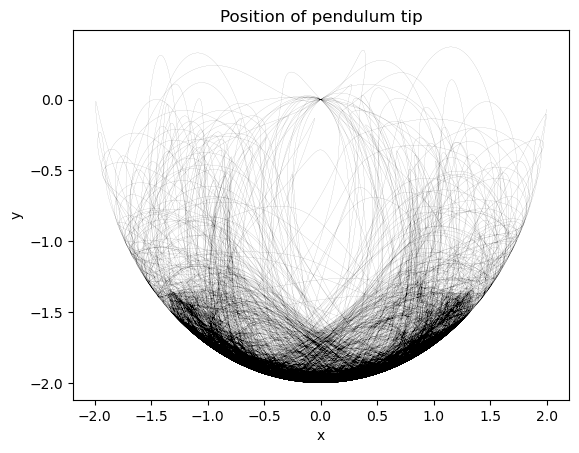

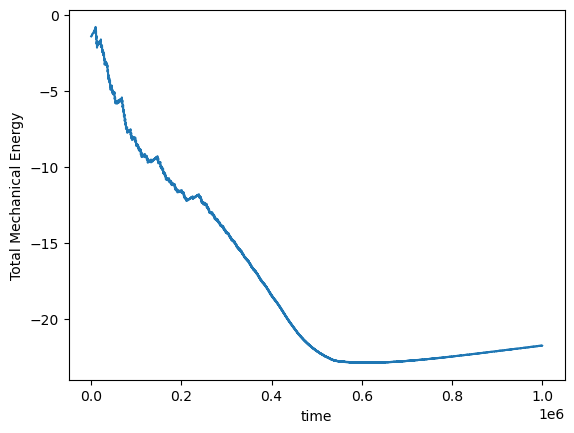

In [130]:
pendulum = DoublePendulum()

# Initial conditions
x0 = np.array([np.pi / 2.1, np.pi / 2, 0.1, 0.2])
t0 = 0.0

# Set up integrator
integrator = SymplecticEuler(dt=1e-3)
integrator.integrate(pendulum, [t0, 1000], x0)

# Convert to physical coordinates
y = pendulum.convert_to_physical(integrator.y)

plt.figure()
plt.plot(y[:, 2], y[:, 3], 'k', linewidth=0.05)
plt.xlabel('x')
plt.ylabel('y')
plt.title("Position of pendulum tip")

plt.figure()
plt.plot(pendulum.compute_energy(integrator.y))
plt.xlabel('time')
plt.ylabel('Total Mechanical Energy')